In [39]:
import numpy as np
np.random.seed(15)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt

# Multivariate

In [58]:
# Load data
target = 'ETH-USD'
start = dt.datetime(2015,1,1)
end = dt.datetime.today()

data = pdr.DataReader(company, 'yahoo', start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,164329.0,2.772120
2015-08-07,2.798810,0.714725,2.793760,0.753325,674188.0,0.753325
2015-08-08,0.879810,0.629191,0.706136,0.701897,532170.0,0.701897
2015-08-09,0.729854,0.636546,0.713989,0.708448,405283.0,0.708448
2015-08-10,1.131410,0.663235,0.708087,1.067860,1463100.0,1.067860


In [41]:
i = 0
x = 1
for n in data.columns.values:
  n = 'add' + str(x)
  data.columns.values[i] = n
  i += 1
  x += 1

data['y'] = data['Close']
data['y'] = data['y'].shift(-1)

data.tail(1)['y'].fillna((float(0)), inplace=True)

data.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,add1,add2,add3,add4,add5,add6,y
Date,,,,,,,
2021-03-08,1835.192139,1670.942017,1724.229248,1834.727905,2.763099e+10,1834.727905,1868.048828
2021-03-09,1868.048828,1804.266357,1835.148071,1868.048828,2.346124e+10,1868.048828,1799.166260
2021-03-10,1873.803223,1766.490479,1868.489014,1799.166260,2.515417e+10,1799.166260,1826.194946
2021-03-11,1843.818848,1734.617065,1798.033936,1826.194946,2.401313e+10,1826.194946,1794.611572
2021-03-12,1839.497314,1794.588989,1815.087891,1794.611572,2.303646e+10,1794.611572,0.000000


In [42]:
df = data.dropna()
df.reset_index(level = 0, inplace = True)
df.rename(columns={'Date': 'ds'}, inplace = True)
next_day = df.tail(1)
df.drop(next_day.index, inplace=True)
df.tail()

,ds,add1,add2,add3,add4,add5,add6,y
2035,2021-03-07,1730.924194,1636.564453,1655.392456,1723.153809,2.380994e+10,1723.153809,1834.727905
2036,2021-03-08,1835.192139,1670.942017,1724.229248,1834.727905,2.763099e+10,1834.727905,1868.048828
2037,2021-03-09,1868.048828,1804.266357,1835.148071,1868.048828,2.346124e+10,1868.048828,1799.166260
2038,2021-03-10,1873.803223,1766.490479,1868.489014,1799.166260,2.515417e+10,1799.166260,1826.194946
2039,2021-03-11,1843.818848,1734.617065,1798.033936,1826.194946,2.401313e+10,1826.194946,1794.611572


In [43]:
train_size = 0.90 # testing only on the very last prices

n_train = round(df.shape[0]*train_size)

# use last days as test data

# train = df[:n_train]
# test = df[n_train:]

# use random days as test data
train = df.drop(index=list(np.random.randint(df.shape[0], size=round(df.shape[0]*(1-train_size)))))
test = df.iloc[list(np.random.randint(df.shape[0], size=round(df.shape[0]*(1-train_size))))]

In [44]:
from fbprophet import Prophet
prophet = Prophet()
for n in data.columns.values[:len(data.columns.values)-1]:
  prophet.add_regressor(n)
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


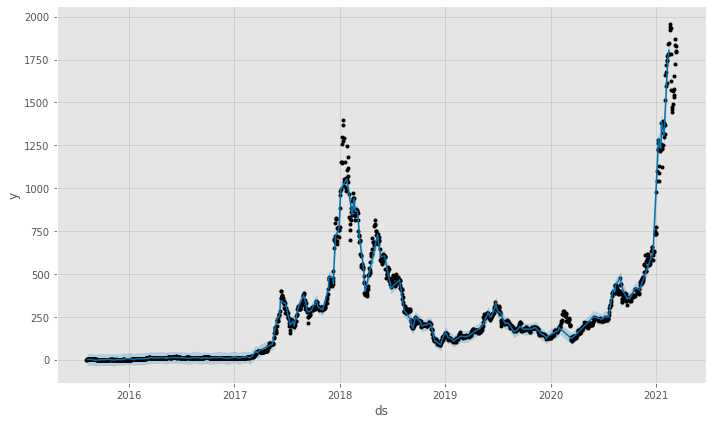

In [51]:
forecast = prophet.predict(test.drop(columns="y"))
plt.style.use('ggplot')
fig = prophet.plot(forecast)

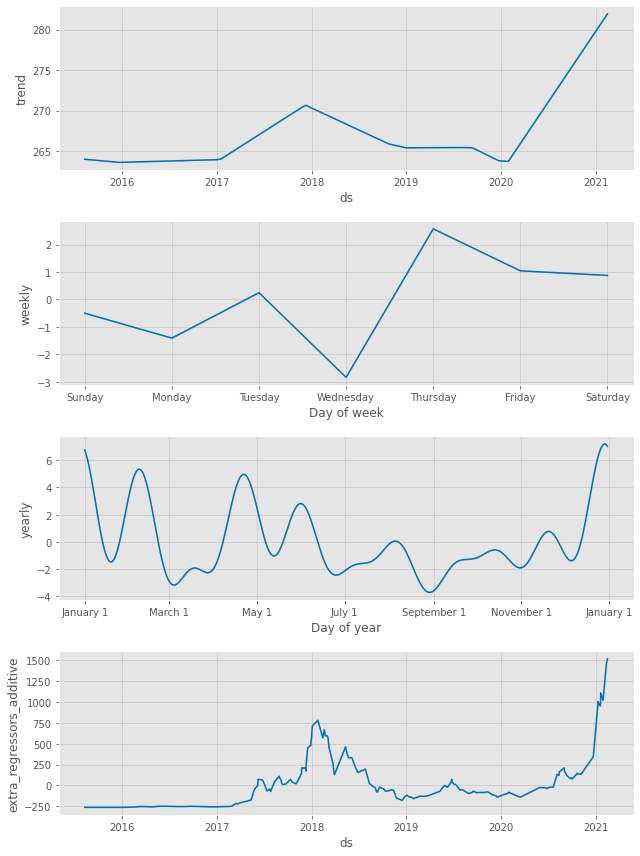

In [52]:
fig = prophet.plot_components(forecast)

In [53]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')

#https://facebook.github.io/prophet/docs/diagnostics.

# cutoffs = pd.to_datetime([str(x.date()) for x in list(df.tail(3)['ds'])])
# df_cv2 = cross_validation(prophet, cutoffs=cutoffs, horizon='365 days')
df_cv2 = cross_validation(prophet, horizon='365 days')

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-09-23 00:00:00 and 2020-03-11 00:00:00


INFO:fbprophet:Making 4 forecasts with cutoffs between 2018-09-10 12:00:00 and 2020-03-11 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,301.096190,17.352124,10.526223,0.041516,0.030794,0.883838
1,37 days,302.656820,17.397035,10.450139,0.040590,0.029874,0.880808
2,38 days,293.106188,17.120344,10.316243,0.040206,0.029874,0.883117
3,39 days,279.162151,16.708146,10.036552,0.039498,0.029417,0.890909
4,40 days,302.517756,17.393038,10.345513,0.039826,0.029417,0.884680


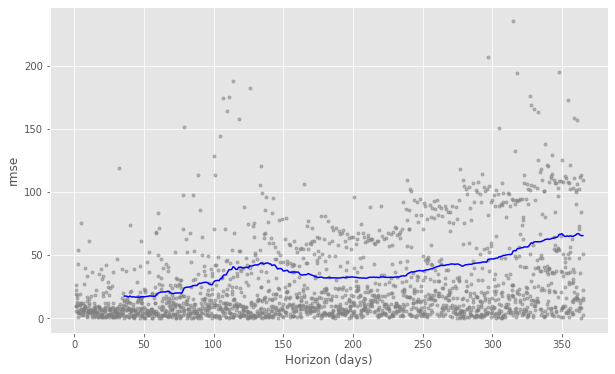

In [54]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [55]:
forecast_next_day = prophet.predict(next_day.drop(columns="y"))
forecast_next_day

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,add2_lower,add2_upper,add3,add3_lower,add3_upper,add4,add4_lower,add4_upper,add5,add5_lower,add5_upper,add6,add6_lower,add6_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-12,283.179013,1755.556355,1820.104134,283.179013,283.179013,221.983578,221.983578,221.983578,-44.050552,-44.050552,-44.050552,-99.138063,-99.138063,-99.138063,714.784079,714.784079,714.784079,-0.566165,-0.566165,-0.566165,714.784079,714.784079,714.784079,1506.468269,1506.468269,1506.468269,1507.796957,1507.796957,1507.796957,1.044265,1.044265,1.044265,-2.372953,-2.372953,-2.372953,0.0,0.0,0.0,1789.647281


In [56]:
date_t = data.tail(1).index.date[0]
price_t = round(float(data.tail(1)['add4']), 2)

date_t1 = data.tail(1).index.date[0] + dt.timedelta(days=1)
prediction = round(float(forecast_next_day['yhat'][0]), 2)

print('Price (t):')
print(f'{date_t} {target} {price_t} \n')

print('Price (t+1):')
print(f'{date_t1} {target} {prediction}')

Price (t):
2021-03-12 ETH-USD 1794.61 

Price (t+1):
2021-03-13 ETH-USD 1789.65
